In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
from scipy import stats
import statsmodels.formula.api as smf
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# load npy file to pandas dataframe
data = np.load("../data/processed/surat_cleaned.npy", allow_pickle=True)
df = pd.DataFrame(data)

# 4. Question Formulation

## 4.2 Research Question 2: Neighborhood Price Premium
**The Question**

After controlling for structural and listing attributes (e.g., `square_feet`, `bhk`, `areaWithType`, `transaction`, `status`, `furnishing`, and floor-related variables such as `floor`, `num_floor`), which localities in Surat exhibit statistically significant price premiums or discounts in `price_per_sqft`?

Concretely, we will extract locality from property_name (e.g., “... in Dindoli Surat”) and estimate each locality’s adjusted premium/discount relative to the market baseline while holding other factors constant.

**Motivation & Benefits**
* **Why this is worth investigating:** Location is typically the strongest driver of real-estate prices, but naive comparisons (e.g., mean price by locality) can be misleading because different localities may have different mixes of property types (BHK, size, furnishing level, etc.). We need an approach that isolates the “pure” location effect.
* **Insights provided:** This analysis produces an evidence-based ranking of localities by adjusted price premium/discount, including uncertainty (confidence intervals). It reveals where price differences persist even after controlling for property attributes.
* **Stakeholders:**
    * **Home buyers**, **sellers**, **brokers/agents**, **investors**, and **property listing platforms** (pricing guidance, valuation, and anomaly detection).
* **Real-world decision:** This informs the decision of choosing a property that offers the best utility-to-price ratio.

# 5. Data analysis

## 5.1 Analysis for Question 2

#### A. Preprocessing
**Workflow**

1.  Extract and clean locality from property_name
    - Use a regex pattern to parse locality names from strings like “... in {locality} Surat”. Standardize spacing/casing and fill missing extractions as "Unknown".
    - Reasoning: Locality is the key grouping variable; extraction must be systematic and reproducible.

2.  Handle rare localities (reduce noise and overfitting)
    - Group localities with very small sample sizes (e.g., fewer than k listings) into an "Other" category.
    - Reasoning: Extremely small groups lead to unstable estimates and exaggerated premiums/discounts
  
3.  Engineer floor-related features
    - Create relative_floor = floor / num_floor (with safe handling when num_floor is zero/missing).
    - Reasoning: The same floor number can mean very different things in low-rise vs high-rise buildings; relative position is more comparable.

4.  Reduce the impact of extreme outliers
    - Apply percentile clipping (e.g., 1st–99th percentile) or an IQR-based rule to `square_feet` and `price_per_sqft`.
    - Reasoning: Real-estate data often contains extreme or noisy listings; robust preprocessing improves model stability.

5.  Log-transform key numeric variables
    - Use **log(price_per_sqft)** as the primary target and log(square_feet).
    - Reasoning: Log transforms reduce right-skew, mitigate outlier influence, and allow locality effects to be interpreted as approximate percentage changes.

In [136]:
# Extract locality from property_name
pattern = r"\bin\s+(.*?)\s+Surat\b"
df["locality"] = df["property_name"].str.extract(pattern, expand=False).str.strip()

df["locality"] = df["locality"].fillna("Unknown")
df["bhk"] = df["bhk"].astype(int)

# Group rare localities
min_count = 5 # threshold = 5 can cover most localities
loc_counts = df["locality"].value_counts()
common_locs = loc_counts[loc_counts >= min_count].index
df["locality_grouped"] = np.where(df["locality"].isin(common_locs), df["locality"], "Other")
# Put "Other" last so Sum coding uses it as the omitted level (stable baseline).
group_counts = df["locality_grouped"].value_counts()
loc_levels = group_counts.index.tolist()
if "Other" in loc_levels:
    loc_levels.remove("Other")
    loc_levels.append("Other")
df["locality_grouped"] = pd.Categorical(df["locality_grouped"], categories=loc_levels)

# Feature engineering
df["relative_floor"] = (df["floor"] / df["num_floor"]).astype(float)

# Outlier trimming (example: 1%–99%)
def clip_by_quantile(s, low=0.01, high=0.99):
    lo, hi = s.quantile(low), s.quantile(high)
    return s.clip(lo, hi)

df["square_feet_c"] = clip_by_quantile(df["square_feet"])
df["price_per_sqft_c"] = clip_by_quantile(df["price_per_sqft"])

df["log_area"] = np.log(df["square_feet_c"])
df["log_price_psf"] = np.log(df["price_per_sqft_c"])

#### B. Analysis

* **Analytical approach**

We estimate locality premiums/discounts using a hedonic pricing regression, where the unit price is modeled as a function of property attributes plus locality indicators.

1.  Baseline descriptive comparison (raw locality differences)

Compute and visualize raw price_per_sqft distributions by locality (e.g., top 10 localities by listing count).

2.  Adjusted comparison via multivariate regression (hedonic model)
-   Fit an OLS regression with the target log(price_per_sqft) and predictors including:

    - `log(square_feet)`, `bhk`

    - categorical controls: `areaWithType`, `transaction`, `status`, `furnishing`

    - floor controls: `relative_floor`

    - locality as categorical effects (preferably coded so results represent premiums/discounts relative to the market baseline)

- Use heteroskedasticity-robust standard errors (e.g., HC3) because prices often show non-constant variance; robust SE improves the reliability of confidence intervals and significance tests.

3.  Convert locality coefficients into interpretable premiums/discounts
For each locality coefficient $\beta$ in log-space, compute:
$$\text{Premium} \% = (\exp (\beta) − 1) \times 100$$

4.  Rank and summarize results with uncertainty
Build a table of localities with premium/discount %, 95% confidence intervals, and p-values (optionally apply multiple-testing control if many localities are tested). Ranking alone can be misleading without uncertainty; intervals communicate estimate reliability.

* **Expected outputs**

- Statistics tables

    - locality_counts: number of listings (n) per locality_grouped after grouping rare localities.

    - raw_locality_stats: n, price_per_sqft_median, price_per_sqft_iqr per locality (top-N by listing count).

    - locality_effects: locality coefficient $\beta$ (log-scale), $\text{premium\_pct} \space \% = (\exp (\beta) − 1) \times 100$, CI_low, CI_high, p_value.

    - model_fit: $R^2$, adjusted $R^2$, and a brief residual summary (e.g., key quantiles).

- Visualizations

    - Boxplot (or violin plot) of raw price_per_sqft distributions by locality (top-N by listings).

    - Error-bar plot of adjusted locality premium/discount (%) with 95% confidence intervals and a 0% reference line.

- Interpretation targets

    - Identify localities whose 95% CI does not cross 0% (statistically significant premium/discount).

    - Rank the top premium and top discount localities and report effect sizes with uncertainty.

    - Explain differences between raw and adjusted results as evidence of confounding from property-mix differences.

In [137]:
locality_counts = (
    df["locality_grouped"]
    .value_counts(dropna=False)
    .rename_axis("locality_grouped")
    .reset_index(name="n")
)

locality_counts.head(15)

,locality_grouped,n
0,Other,1028
1,Vesu,139
2,Pal,131
3,Adajan,119
4,Palanpur,113
5,Althan,68
6,Jahangirabad,67
7,Dindoli,44
8,Piplod,34
9,Dumas Road,33


In [138]:
top_n = 10
top_localities = locality_counts["locality_grouped"].head(top_n).tolist()

def iqr(x: pd.Series) -> float:
    return x.quantile(0.75) - x.quantile(0.25)

raw_locality_stats = (
    df[df["locality_grouped"].isin(top_localities)]
    .groupby("locality_grouped", observed=True)["price_per_sqft_c"]
    .agg(
        n="count",
        price_per_sqft_median="median",
        price_per_sqft_iqr=iqr,
    )
    .reset_index()
    .sort_values("n", ascending=False)
)

raw_locality_stats

,locality_grouped,n,price_per_sqft_median,price_per_sqft_iqr
9,Other,1028,4351.0,2003.75
0,Vesu,139,5871.0,1150.50
1,Pal,131,4649.0,831.50
2,Adajan,119,4089.0,2484.50
3,Palanpur,113,3815.0,762.00
4,Althan,68,4220.0,697.00
5,Jahangirabad,67,3371.0,756.50
6,Dindoli,44,2839.0,650.00
7,Piplod,34,6195.0,4050.50
8,Dumas Road,33,4500.0,500.00


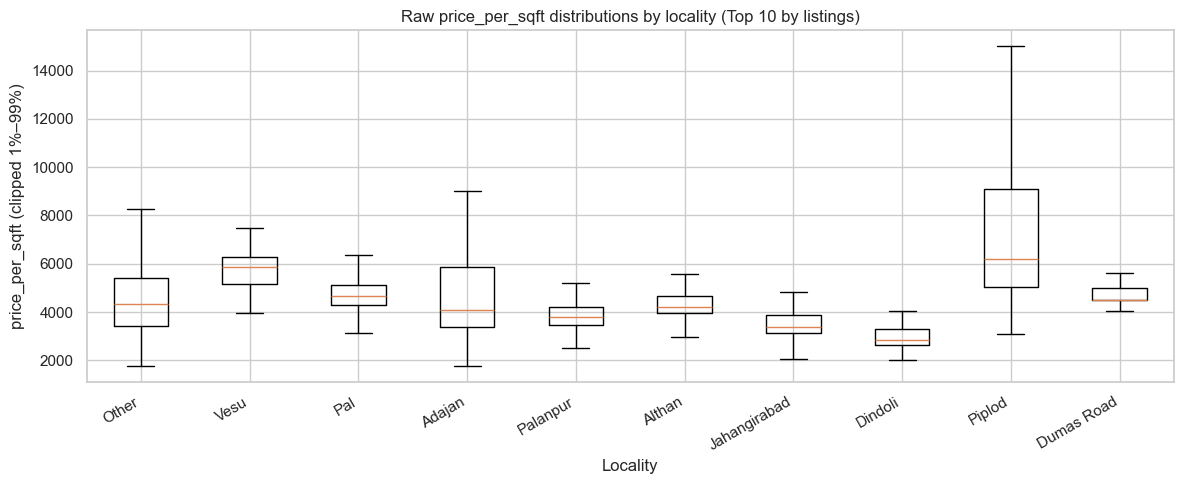

In [139]:
plot_df = df[df["locality_grouped"].isin(top_localities)].copy()
plot_df["locality_grouped"] = plot_df["locality_grouped"].cat.remove_unused_categories()

x_order = top_localities

data = [
    plot_df.loc[plot_df["locality_grouped"] == loc, "price_per_sqft_c"].values
    for loc in x_order
]

plt.figure(figsize=(12, 5))
plt.boxplot(data, labels=x_order, showfliers=False)
plt.title("Raw price_per_sqft distributions by locality (Top 10 by listings)")
plt.xlabel("Locality")
plt.ylabel("price_per_sqft (clipped 1%–99%)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [140]:
model_cols = [
    "log_price_psf",
    "log_area",
    "bhk",
    "areaWithType",
    "transaction",
    "status",
    "furnishing",
    "relative_floor",
    "locality_grouped",
]

model_df = df[model_cols].dropna().copy()
model_df["locality_grouped"] = model_df["locality_grouped"].cat.remove_unused_categories()
print("Rows for modeling:", len(model_df))

formula = (
    "log_price_psf ~ log_area + bhk "
    "+ C(areaWithType) + C(transaction) + C(status) + C(furnishing) "
    "+ relative_floor "
    "+ C(locality_grouped, Sum)"
)

hedonic_model = smf.ols(formula, data=model_df).fit(cov_type="HC3")

Rows for modeling: 3003


In [141]:
params = hedonic_model.params
conf_int = hedonic_model.conf_int()
cov = hedonic_model.cov_params()

# Extract Sum-coded locality coefficients (K-1 terms)
loc_term_prefix = "C(locality_grouped, Sum)"
loc_mask = params.index.str.contains(loc_term_prefix, regex=False)

loc_params = params[loc_mask]
loc_conf = conf_int.loc[loc_params.index]

# Convert to % premium/discount for the estimated levels (K-1)
premium_pct = (np.exp(loc_params) - 1) * 100
ci_low = (np.exp(loc_conf[0]) - 1) * 100
ci_high = (np.exp(loc_conf[1]) - 1) * 100

loc_effects = pd.DataFrame({
    "term": loc_params.index,
    "beta_log": loc_params.values,
    "premium_pct": premium_pct.values,
    "ci_low": ci_low.values,
    "ci_high": ci_high.values,
    "p_value": hedonic_model.pvalues[loc_params.index].values,
})

# Add the omitted level (Sum coding): beta_omitted = -sum(other betas)
# This gives a complete table for ALL locality levels.
all_levels = model_df["locality_grouped"].cat.categories.tolist()
estimated_levels = []

for t in loc_effects["term"]:
    # term looks like: C(locality_grouped, Sum)[S.<level>]
    level = t.split("[S.")[-1].rstrip("]")
    estimated_levels.append(level)

omitted_levels = [lvl for lvl in all_levels if lvl not in estimated_levels]
if len(omitted_levels) != 1:
    raise ValueError("Unexpected Sum coding: cannot identify a single omitted level.")

omitted_level = omitted_levels[0]

# Compute SE for omitted coefficient using covariance matrix (linear combination)
w = np.ones(len(loc_params)) * (-1.0)
cov_sub = cov.loc[loc_params.index, loc_params.index].values
var_omitted = w @ cov_sub @ w
se_omitted = float(np.sqrt(var_omitted))

beta_omitted = float(-loc_params.sum())
t_stat = beta_omitted / se_omitted
p_omitted = 2 * (1 - stats.t.cdf(abs(t_stat), df=hedonic_model.df_resid))

ci_omitted_low = beta_omitted - 1.96 * se_omitted
ci_omitted_high = beta_omitted + 1.96 * se_omitted

omitted_row = pd.DataFrame({
    "term": [f"{loc_term_prefix}[S.{omitted_level}] (implied)"],
    "beta_log": [beta_omitted],
    "premium_pct": [(np.exp(beta_omitted) - 1) * 100],
    "ci_low": [(np.exp(ci_omitted_low) - 1) * 100],
    "ci_high": [(np.exp(ci_omitted_high) - 1) * 100],
    "p_value": [p_omitted],
})

loc_effects = pd.concat([loc_effects, omitted_row], ignore_index=True)

# Add a clean locality column
def parse_level(term: str) -> str:
    if "(implied)" in term:
        return term.split("[S.")[-1].split("]")[0]
    return term.split("[S.")[-1].rstrip("]")

loc_effects["locality_grouped"] = loc_effects["term"].apply(parse_level)

locality_effects = (
    loc_effects[[
        "locality_grouped",
        "beta_log",
        "premium_pct",
        "ci_low",
        "ci_high",
        "p_value",
    ]]
    .sort_values("premium_pct", ascending=False)
    .reset_index(drop=True)
)

locality_effects.tail(10)

,locality_grouped,beta_log,premium_pct,ci_low,ci_high,p_value
143,"Green City, Pal",-0.331131,-28.188868,-33.477555,-22.479719,2.181339e-17
144,Bamroli,-0.346080,-29.254401,-44.131104,-10.416347,4.063819e-03
145,Kim,-0.349206,-29.475245,-49.204329,-2.083367,3.700471e-02
146,Narthan,-0.349892,-29.523569,-41.103236,-15.667229,1.331047e-04
147,Masma Village,-0.390168,-32.305714,-50.264537,-7.862196,1.311760e-02
148,Bardoli,-0.395633,-32.674621,-47.835668,-13.107165,2.371767e-03
149,Palsana,-0.469428,-37.464000,-47.464467,-25.559882,1.291528e-07
150,Sachin,-0.511823,-40.059806,-51.257287,-26.289969,1.228154e-06
151,Sayan,-0.522565,-40.700242,-54.846457,-22.122140,1.712356e-04
152,Olpad Sayan Road,-0.634075,-46.957400,-65.289253,-18.943909,3.381681e-03


In [142]:
resid = hedonic_model.resid

model_fit = pd.DataFrame({
    "metric": ["R2", "adj_R2", "n_obs"],
    "value": [hedonic_model.rsquared, hedonic_model.rsquared_adj, hedonic_model.nobs],
})

residual_summary = resid.quantile([0.0, 0.25, 0.5, 0.75, 1.0]).to_frame("resid_quantile")
residual_summary.index = ["min", "q1", "median", "q3", "max"]

model_fit, residual_summary

(   metric        value
 0      R2     0.414119
 1  adj_R2     0.380917
 2   n_obs  3003.000000,
         resid_quantile
 min          -1.516840
 q1           -0.125731
 median       -0.013107
 q3            0.096263
 max           1.652532)

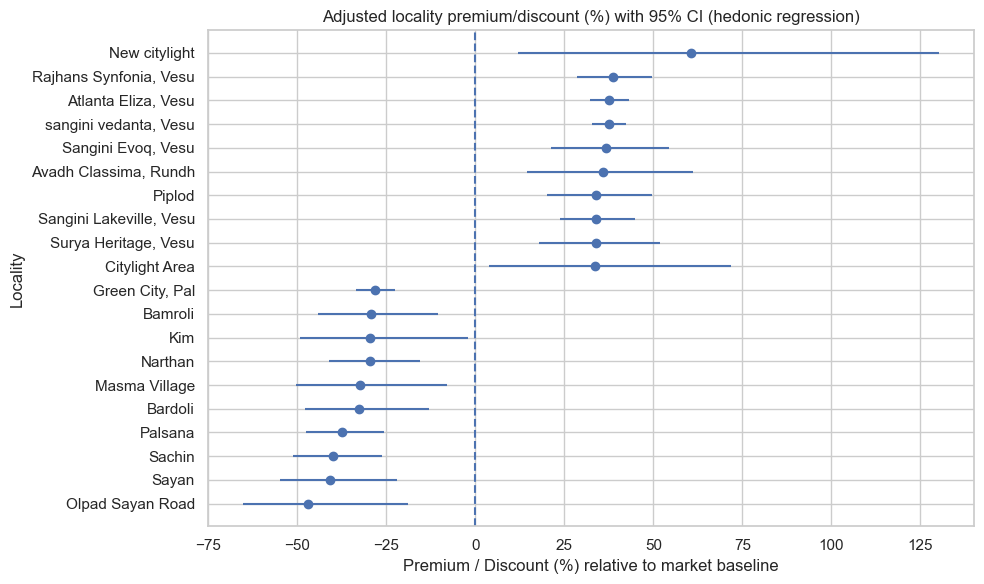

In [143]:
# To keep the plot readable, show the top 10 premiums and top 10 discounts.
top_k = 10
top_premium = locality_effects.head(top_k)
top_discount = locality_effects.tail(top_k)

plot_effects = pd.concat([top_premium, top_discount], axis=0).copy()
plot_effects = plot_effects.sort_values("premium_pct")

x = plot_effects["premium_pct"].values
y = plot_effects["locality_grouped"].values
xerr_low = x - plot_effects["ci_low"].values
xerr_high = plot_effects["ci_high"].values - x

plt.figure(figsize=(10, 6))
plt.errorbar(
    x=x,
    y=np.arange(len(y)),
    xerr=[xerr_low, xerr_high],
    fmt="o",
)
plt.axvline(0, linestyle="--")
plt.yticks(np.arange(len(y)), y)
plt.title("Adjusted locality premium/discount (%) with 95% CI (hedonic regression)")
plt.xlabel("Premium / Discount (%) relative to market baseline")
plt.ylabel("Locality")
plt.tight_layout()
plt.show()


In [144]:
locality_effects["significant_95"] = ~(
    (locality_effects["ci_low"] <= 0) & (locality_effects["ci_high"] >= 0)
)

top_premiums = locality_effects.head(10)
top_discounts = locality_effects.tail(10)

top_premiums[["locality_grouped", "premium_pct", "ci_low", "ci_high", "p_value",
              "significant_95"]]

,locality_grouped,premium_pct,ci_low,ci_high,p_value,significant_95
0,New citylight,60.553548,11.946924,130.264852,1.007173e-02,True
1,"Rajhans Synfonia, Vesu",38.659357,28.630812,49.469765,1.424533e-17,True
2,"Atlanta Eliza, Vesu",37.585903,32.124348,43.273219,8.859485e-54,True
3,"sangini vedanta, Vesu",37.494669,32.775984,42.381049,1.989165e-71,True
4,"Sangini Evoq, Vesu",36.726945,21.172458,54.278106,3.842285e-07,True
5,"Avadh Classima, Rundh",35.850238,14.538516,61.127346,4.330764e-04,True
6,Piplod,33.988889,20.097870,49.486600,1.610385e-07,True
7,"Sangini Lakeville, Vesu",33.832088,23.715450,44.775998,3.687608e-13,True
8,"Surya Heritage, Vesu",33.812481,17.934586,51.828066,6.193422e-06,True
9,Citylight Area,33.557538,3.875772,71.720657,2.403977e-02,True


In [145]:
top_discounts[["locality_grouped", "premium_pct", "ci_low", "ci_high", "p_value",
               "significant_95"]]

,locality_grouped,premium_pct,ci_low,ci_high,p_value,significant_95
143,"Green City, Pal",-28.188868,-33.477555,-22.479719,2.181339e-17,True
144,Bamroli,-29.254401,-44.131104,-10.416347,4.063819e-03,True
145,Kim,-29.475245,-49.204329,-2.083367,3.700471e-02,True
146,Narthan,-29.523569,-41.103236,-15.667229,1.331047e-04,True
147,Masma Village,-32.305714,-50.264537,-7.862196,1.311760e-02,True
148,Bardoli,-32.674621,-47.835668,-13.107165,2.371767e-03,True
149,Palsana,-37.464000,-47.464467,-25.559882,1.291528e-07,True
150,Sachin,-40.059806,-51.257287,-26.289969,1.228154e-06,True
151,Sayan,-40.700242,-54.846457,-22.122140,1.712356e-04,True
152,Olpad Sayan Road,-46.957400,-65.289253,-18.943909,3.381681e-03,True


#### C. Results & Interpretation 

**Visualizations**

**Figure 1** — Raw price_per_sqft distributions by locality (Top 10 by listings, clipped 1%–99%)
This boxplot summarizes the unadjusted (raw) price-per-sqft variation across the most frequent localities in the dataset. Several patterns stand out:

- Higher raw medians are observed in Piplod (median 6195) and Vesu (median 5871), suggesting these are “expensive” areas in a simple comparison.

- Lower raw medians appear in Dindoli (median 2839) and Jahangirabad (median 3371), indicating cheaper markets on average.

- The spread differs substantially by locality. For example, Piplod has a very wide IQR (4050.5), implying large within-locality heterogeneity (different property types/quality levels).

- “Other” (n = 1028) has a mid-range median (4351) but a large IQR (2003.75). This is expected because it aggregates many rare localities and is not a single coherent neighborhood.

- **Interpretation:** Raw comparisons are informative as a first look, but they can be misleading because each locality has a different “property mix” (area sizes, BHK distribution, furnishing, transaction types, etc.). This motivates the adjusted (hedonic) analysis.

**Figure 2** — Adjusted locality premium/discount (%) with 95% CI (hedonic regression, HC3 robust SE)
This plot reports the estimated location premium/discount after controlling for structural and listing attributes (e.g., log_area, bhk, areaWithType, transaction, status, furnishing, relative_floor). Each point is a locality effect expressed as:

$$\text{premium\_pct} \space \% = (\exp (\beta) − 1) \times 100$$

The horizontal bars show the 95% confidence interval (CI); effects whose CI does not cross 0% are statistically significant at the 5% level.

**Quantitative evidence** 

**1) Model strength and reliability** (context for interpretation)

- The hedonic model uses n = 3003 listings and achieves R² = 0.414 and Adj. R² = 0.381, indicating the covariates explain a substantial portion of variation in log_price_psf, while still leaving room for unobserved factors (amenities, age, exact micro-location, etc.).

- Residuals are centered near zero (median residual ≈ -0.013), but the min/max residuals (-1.52, +1.65) indicate remaining outliers/extremes—typical in real estate data.

- We report HC3 robust standard errors, so confidence intervals and p-values are less sensitive to non-constant variance (heteroskedasticity) that is common in housing prices.

**2) Raw vs. adjusted locality signals**(why the regression matters)

The raw boxplot suggests “expensive” localities such as Piplod and Vesu (raw medians 6195 and 5871, respectively), while Dindoli appears cheaper (median 2839).

However, the adjusted results show that some of the strongest premiums are concentrated in specific micro-localities/projects, especially within or near Vesu/Citylight/Piplod. This highlights confounding: raw medians reflect both “location value” and “property mix.”

**3) Top adjusted premiums** (location effect after controls)

All top premiums below are statistically significant (95% CI does not cross 0):

- New citylight: +60.6% premium (95% CI [+11.9%, +130.3%], p = 0.010).
The effect is large but the CI is wide, suggesting smaller sample size and higher uncertainty than other top entries.

- Rajhans Synfonia, Vesu: +38.7% (CI [+28.6%, +49.5%], p ≈ 1.4e-17)

- Atlanta Eliza, Vesu: +37.6% (CI [+32.1%, +43.3%], p ≈ 8.9e-54)

- sangini vedanta, Vesu: +37.5% (CI [+32.8%, +42.4%], p ≈ 2.0e-71)

- Piplod: +34.0% (CI [+20.1%, +49.5%], p ≈ 1.6e-07)

- Citylight Area: +33.6% (CI [+3.9%, +71.7%], p = 0.024) — also positive but with wider uncertainty.

**Practical implication**: For a buyer comparing properties with similar size/BHK/furnishing/status, these areas/projects are priced materially above the market baseline, suggesting stronger demand, perceived desirability, or higher quality micro-location.

**4) Top adjusted discounts** (cheaper after controls)

All top discounts below are statistically significant:

- Olpad Sayan Road: -47.0% discount (CI [-65.3%, -18.9%], p = 0.0034)

- Sayan: -40.7% (CI [-54.8%, -22.1%], p ≈ 1.7e-04)

- Sachin: -40.1% (CI [-51.3%, -26.3%], p ≈ 1.2e-06)

- Palsana: -37.5% (CI [-47.5%, -25.6%], p ≈ 1.3e-07)

- Green City, Pal: -28.2% (CI [-33.5%, -22.5%], p ≈ 2.2e-17)

- Kim: -29.5% (CI [-49.2%, -2.1%], p = 0.037) — significant, but near the threshold and relatively uncertain.

**Practical implication**: These areas appear systematically cheaper than the market baseline even after controlling for key listing attributes, which can inform affordability searches, investment screening, or price negotiation strategy.

**Surprises / notable observations**

- The adjusted “top premium” list is dominated by micro-localities/projects (e.g., multiple entries within Vesu), which suggests that within-locality segmentation is important: “Vesu” as a broad locality may not capture the true high-premium pockets on its own.

- Some raw distributions show large spreads (e.g., Piplod, Adajan), indicating heterogeneous property mixes. The regression helps isolate the portion attributable to location rather than composition.

**Limitations** (important to acknowledge)

- Locality extraction from property_name can produce mixed granularity (neighborhood vs. project name). This may inflate the number of categories and create small-sample localities with wider CIs (e.g., New citylight).

- Omitted variables (e.g., building age, amenities, exact coordinates, distance to CBD, developer reputation) may still confound locality effects.

- Results are based on cross-sectional listings and do not model time dynamics (market changes over time).

- With ~150 localities, there are many simultaneous significance tests; while top effects are strong, marginal cases should be interpreted cautiously.

- Outlier handling via 1%–99% clipping stabilizes estimates but may under-represent extreme segments of the market.